CONTENTS:
- [Github API to understand user Contribution](#github-api-to-understand-user-contribution)
- [Authenticate GitHub Client](#authenticate-github-client)
- [Define Time Period](#define-time-period)
- [Specify Users and Repos to Fetch and Cache Data](#specify-users-and-repos-to-fetch-and-cache-data)
  - [Pre-fetch all the data you need in cache](#pre-fetch-all-the-data-you-need-in-cache)
- [Collect Daily Metrics](#collect-daily-metrics)
- [Summarize Contributions and Visualize for Entire period that was cached](#summarize-contributions-and-visualize-for-entire-period-that-was-cached)
  - [a. Compare users Total performance across selected repos](#a.-compare-users-total-performance-across-selected-repos)
  - [b. Compare a users performance Individually across repos](#b.-compare-a-users-performance-individually-across-repos)
  - [c. Compare Multiple users inside one repo](#c.-compare-multiple-users-inside-one-repo)
- [Performance Evaluation](#performance-evaluation)

<a name='github-api-to-understand-user-contribution'></a>
# Github API to understand user Contribution

These numbers come straight from the upstream repo via the REST API, so they only include commits and PRs where you’re the author or the committer on that repo. They **do not** pick up any work you did in a fork (or the individual commits squashed into a single merge), which is why they’ll always undercount what GitHub Insights shows for your overall contributions.


In [27]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim PyGithub)"
!jupyter labextension enable

In [28]:
import datetime
import logging
import os

import github_utils

# Enable logging.
logging.basicConfig(level=logging.INFO)
_LOG = logging.getLogger(__name__)

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='authenticate-github-client'></a>
# Authenticate GitHub Client

In [6]:
# Set your GitHub access token.
os.environ["GITHUB_ACCESS_TOKEN"] = ""

In [7]:
access_token = os.getenv("GITHUB_ACCESS_TOKEN")
if not access_token:
    _LOG.error("GITHUB_ACCESS_TOKEN not set. Exiting.")
    raise ValueError("Set GITHUB_ACCESS_TOKEN environment variable")

client = github_utils.GitHubAPI(access_token=access_token).get_client()

In [8]:
users = github_utils.get_contributors_for_repo(
    client, "causify-ai", "tutorials", top_n=30
)
print(users)

INFO:github_utils:Fetched 30 contributors for causify-ai/tutorials


['sonaalKant', 'tkpratardan', 'gpsaggese', 'heanhsok', 'sonniki', 'aangelo9', 'Prahar08modi', 'Shaunak01', 'indrayudd', 'Swapnika29', 'Rohan-Ambati', 'protocorn', 'sathwikhnaik', 'ksurya14', 'SivaRajes', 'ojasonu', 'dhruv2009', 'rishikathakre', 'rkoush', 'Eyepatch0', 'gouravreddy02', 'beas28la', 'Jd8111997', 'bashaboinamanojkumar', 'Mayur074', 'x-claimer', 'mkdatadive', 'ReetikaaGajula2002', 'RithikaBaskaran', 'Ritik294']


<a name='define-time-period'></a>
# Define Time Period

In [9]:
# Use a long window for caching and a narrow slice for final analysis.
period_full = github_utils.utc_period("2024-01-01", "2025-06-01")
period_slice = github_utils.utc_period("2025-04-01", "2025-05-31")

<a name='specify-users-and-repos-to-fetch-and-cache-data'></a>
# Specify Users and Repos to Fetch and Cache Data

In [10]:
# Choose your users and repositories.
users = [
    "Shaunak01",
    "tkpratardan",
    "Prahar08modi",
    "sandeepthalapanane",
    "indrayudd",
    "Swapnika29",
    "mongolianjesus",
    "cma0416",
]
repos = ["helpers", "tutorials", "cmamp"]
org = "causify-ai"

<a name='pre-fetch-all-the-data-you-need-in-cache'></a>
<a name='pre-feth-all-the-data-you-need-in-cache'></a>
## Pre-fetch all the data you need in cache

Query extraction takes time, so prefetch all data in cache for all the users, repos and time frames you need. once in cache there are several utility functions to help understand the user contribution. Following is the data we will fetch for users in multiple repos for the given period.
- Prs opened in the repo
- Commits done
- LOC [additions and deletions]

In [12]:
# This will call the GitHub API and write results to disk.
github_utils.prefetch_periodic_user_repo_data(
    client, org, repos, users, period_full
)

Prefetching user-repo data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 406.38it/s]
INFO:github_utils:Prefetched 24 user-repo combos in 0.06 seconds for period 2024-01-01 00:00:00+00:00 to 2025-06-01 00:00:00+00:00.


helpers/Shaunak01: 23 commits, 30 PRs, 23 LOC entries, 39 issues assigned, 30 closed
helpers/tkpratardan: 6 commits, 7 PRs, 6 LOC entries, 5 issues assigned, 5 closed
helpers/Prahar08modi: 0 commits, 0 PRs, 0 LOC entries, 0 issues assigned, 0 closed
helpers/sandeepthalapanane: 20 commits, 26 PRs, 20 LOC entries, 24 issues assigned, 15 closed
helpers/indrayudd: 10 commits, 11 PRs, 10 LOC entries, 14 issues assigned, 10 closed
helpers/Swapnika29: 0 commits, 0 PRs, 0 LOC entries, 0 issues assigned, 0 closed
helpers/mongolianjesus: 1 commits, 1 PRs, 1 LOC entries, 0 issues assigned, 0 closed
helpers/cma0416: 0 commits, 0 PRs, 0 LOC entries, 0 issues assigned, 0 closed
tutorials/Shaunak01: 1 commits, 4 PRs, 1 LOC entries, 4 issues assigned, 2 closed
tutorials/tkpratardan: 16 commits, 21 PRs, 16 LOC entries, 16 issues assigned, 11 closed
tutorials/Prahar08modi: 6 commits, 7 PRs, 6 LOC entries, 11 issues assigned, 7 closed
tutorials/sandeepthalapanane: 0 commits, 0 PRs, 0 LOC entries, 0 issue

<a name='collect-daily-metrics'></a>
# Collect Daily Metrics

In [13]:
# This data has one row per (user, repo, date) with metrics: commits, PRs, issues, LOC changes.
combined_df = github_utils.collect_all_metrics(
    client, org, repos, users, period_full
)

In [23]:
print(len(combined_df))
combined_df[904:].head()

12432


,date,commits,repo,user,prs,additions,deletions,issues_assigned,issues_closed
904,2025-01-21,1,helpers,tkpratardan,1,+194,-8,0,1
905,2025-01-22,0,helpers,tkpratardan,0,+0,-0,0,0
906,2025-01-23,1,helpers,tkpratardan,1,+258,-114,0,1
907,2025-01-24,0,helpers,tkpratardan,0,+0,-0,0,0
908,2025-01-25,0,helpers,tkpratardan,0,+0,-0,0,0


<a name='summarize-contributions-and-visualize-for-entire-period-that-was-cached'></a>
# Summarize Contributions and Visualize for Entire period that was cached

<a name='a.-compare-users-total-performance-across-selected-repos'></a>
## a. Compare users Total performance across selected repos

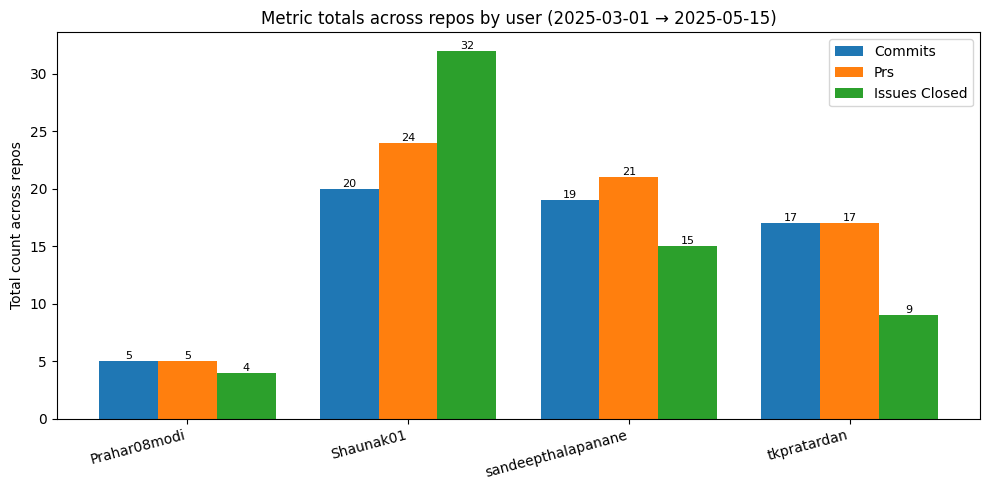

In [30]:
github_utils.plot_multi_metrics_totals_by_user(
    combined=combined_df,
    metrics=["commits", "prs", "issues_closed"],
    users=["Shaunak01", "tkpratardan", "Prahar08modi", "sandeepthalapanane"],
    repos=repos,
    start=datetime.datetime(2025, 3, 1),
    end=datetime.datetime(2025, 5, 15),
)

<a name='b.-compare-a-users-performance-individually-across-repos'></a>
## b. Compare a users performance Individually across repos

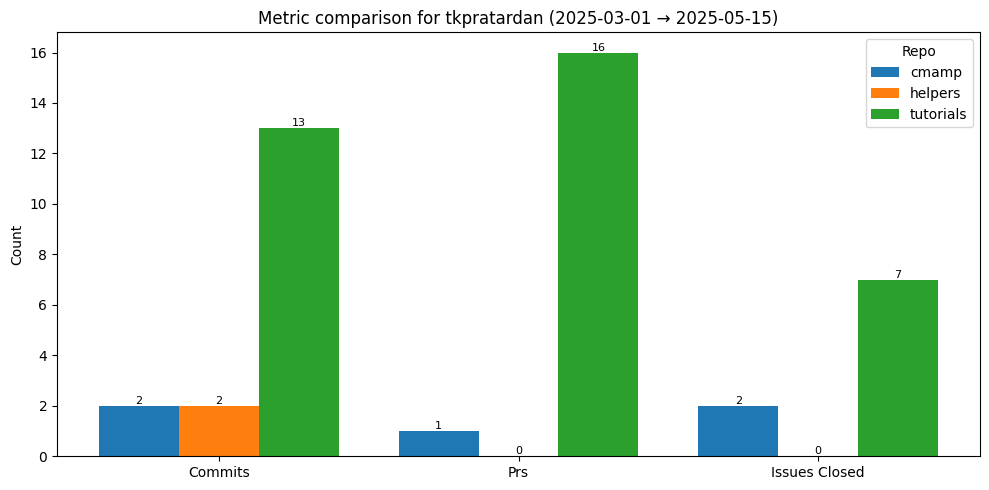

In [31]:
github_utils.plot_metrics_by_repo(
    combined=combined_df,
    user="tkpratardan",
    metrics=["commits", "prs", "issues_closed"],
    start=datetime.datetime(2025, 3, 1),
    end=datetime.datetime(2025, 5, 15),
)

<a name='c.-compare-multiple-users-inside-one-repo'></a>
## c. Compare Multiple users inside one repo

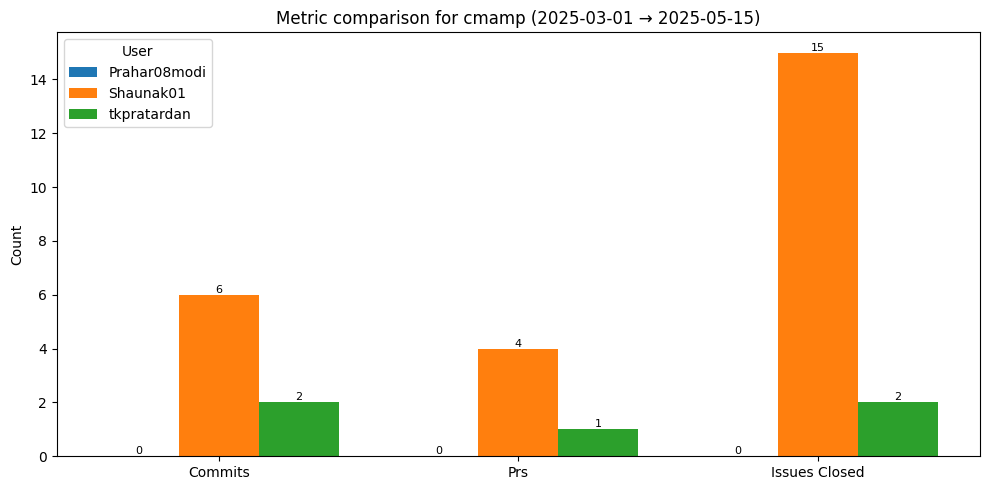

In [32]:
github_utils.plot_metrics_by_user(
    combined=combined_df,
    repo="cmamp",
    users=["tkpratardan", "Shaunak01", "Prahar08modi"],
    metrics=["commits", "prs", "issues_closed"],
    start=datetime.datetime(2025, 3, 1),
    end=datetime.datetime(2025, 5, 15),
)

<a name='performance-evaluation'></a>
# Performance Evaluation


📊 User performance (Z):



,commits_z,prs_z,issues_closed_z
user,,,
Prahar08modi,-1.07,-1.05,-0.93
Shaunak01,1.20,1.26,1.30
sandeepthalapanane,-0.51,-0.48,-0.62
tkpratardan,0.38,0.28,0.25


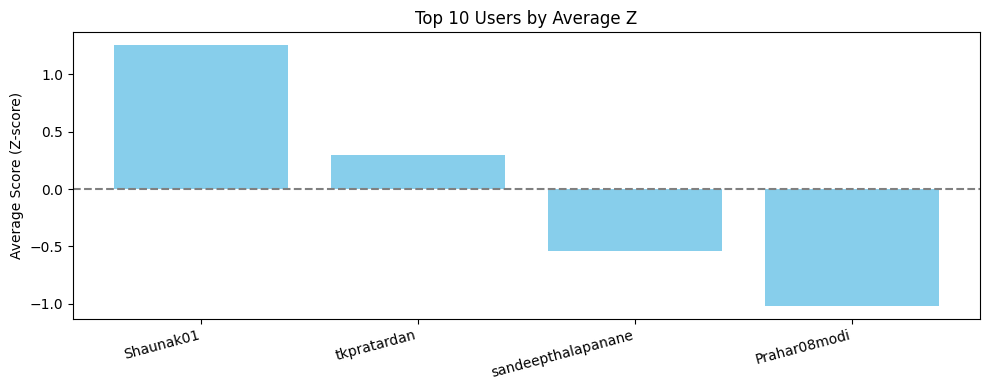


📊 User performance (Percentile):



,commits_pctile,prs_pctile,issues_closed_pctile
user,,,
Prahar08modi,0.25,0.25,0.25
Shaunak01,1.00,1.00,1.00
sandeepthalapanane,0.50,0.50,0.50
tkpratardan,0.75,0.75,0.75


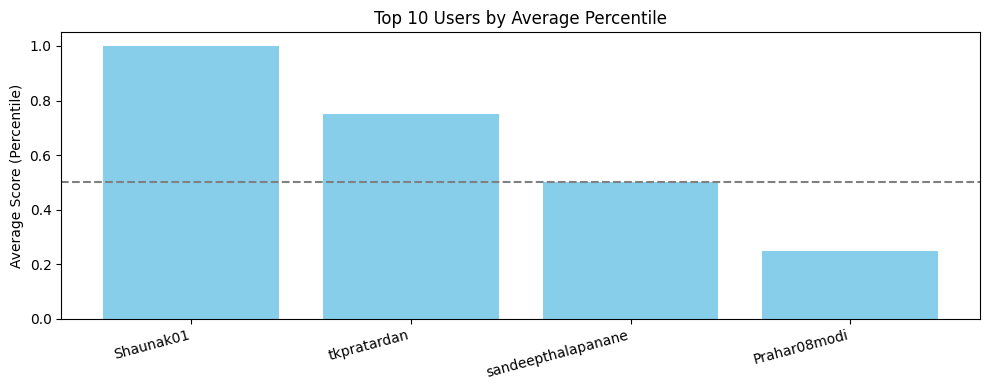

In [54]:
# Step 0: Define your slice
users = ["Shaunak01", "tkpratardan", "Prahar08modi", "sandeepthalapanane"]
repos = ["cmamp", "helpers"]
metrics = ["commits", "prs", "issues_closed"]

# Step 1: Summarize total metrics across users/repos
summary_users = github_utils.summarize_users_across_repos(
    combined_df, users=users, repos=repos
)

# Step 2: Add z-scores and percentiles
z_df = github_utils.compute_z_scores(summary_users, metrics)
stats = github_utils.compute_percentile_ranks(z_df, metrics)

# Step 3: Visualize — will automatically pick up all *_z or *_pctile columns
github_utils.visualize_user_metric_comparison(stats, score_type="z")
github_utils.visualize_user_metric_comparison(stats, score_type="percentile")

There are many more helper funcs to see and compare statistics. Look at github_utils for more info -> `docker_causify_style/github_utils.py`